In [20]:
from mpl_toolkits.mplot3d import Axes3D
import scipy
import scipy.integrate
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

In [102]:
# These are our constants
N = 5  # Number of variables
f = 8  # Forcing

In [155]:
# Adapted from https://en.wikipedia.org/wiki/Lorenz_96_model
def L96(t, X):
    """Lorenz 96 model with constant forcing"""
    # Setting up vector
    Y = np.zeros(N)
    # Loops over indices (with operations and Python underflow indexing handling edge cases)
    for i in range(N):
        Y[i] = (X[(i + 1) % N] - X[i - 2]) * X[i - 1] - X[i] + f
    return Y


In [156]:
# initial condition setup
X0 = f * np.ones(N)
epsilon = np.zeros(N)
# note this is a little farther from equilibrium. want dynamics to not
# evolve from null
epsilon += 1*np.random.randn(N)

X0 += epsilon

In [157]:
# integrator fidelity & time points setup
t0 = 0.0
t_step = 0.1
T = 2.0
t_np = np.arange(0.0, T, t_step)
t = torch.from_numpy(t_np)

In [158]:
# run the numerical integrator
RK45_result = scipy.integrate.solve_ivp(L96, (t0, T), X0, 'RK45', dense_output=True)


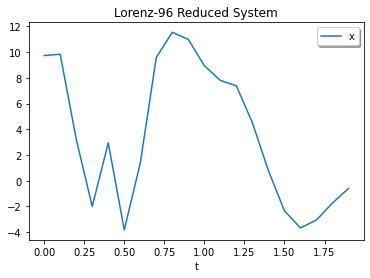

In [159]:
z = RK45_result.sol(t)[3]
# z = 0.01*np.sum(z, axis=0)
plt.plot(t_np, z.T)
plt.xlabel('t')
plt.legend(['x', 'y'], shadow=True)
plt.title('Lorenz-96 Reduced System')
plt.show()

## New Model: NN map to hidden state that linearizes dynamics

In [160]:
# Neural network to learn mapping to hidden state space
class LinearizationNet(nn.Module):

    # n is the dimension of the observed state y
    def __init__(self, n, d):
        super(LinearizationNet, self).__init__()
        # an affine operation: y = Wx + b
        # self.fc_0 = nn.Linear(n, 500)  
        # self.fc_1 = nn.Linear(500, d)
        self.fc_0 = nn.Linear(n, d)  
        self.fc_1 = nn.Linear(d, d)
        self.fc_2 = nn.Linear(d, d)
        self.fc_3 = nn.Linear(d, d)
        self.fc_4 = nn.Linear(d, d)
        self.fc_5 = nn.Linear(d, d)
        self.fc_6 = nn.Linear(d, d)


    def forward(self, x):

        # feed observed state into hidden state
        x = F.relu(self.fc_0(x))
        # Layer Normalization
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        # pass through residual connections a number of times
        x = x + F.relu(self.fc_1(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_2(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_3(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_4(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_5(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)


        x = x + self.fc_6(x)

        # x = F.relu(self.fc_0(x))
        # x = self.fc_1(x)

        return x

# Neural network to learn inverse of LinearizationNet
class ReconstructionNet(nn.Module):

    # n is the dimension of the observed state y
    def __init__(self, n, d):
        super(ReconstructionNet, self).__init__()
        # an affine operation: y = Wx + b
        # FC
        # self.fc_3 = nn.Linear(500, n)
        # self.fc_2 = nn.Linear(d, 500)
        # ResNet

        self.fc_6 = nn.Linear(d, n)
        self.fc_5 = nn.Linear(d, d)
        self.fc_4 = nn.Linear(d, d)
        self.fc_3 = nn.Linear(d, d)
        self.fc_2 = nn.Linear(d, d)
        self.fc_1 = nn.Linear(d, d)
        self.fc_0 = nn.Linear(d, d)

    def forward(self, x):

        # pass through residual connections a number of times
        x = x + F.relu(self.fc_0(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_1(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_2(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_3(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_4(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)
        x = x + F.relu(self.fc_5(x))
        x = (x - x.mean(1).reshape(-1,1)) / x.std(1).reshape(-1, 1)

        # feed observed state into hidden state
        x = self.fc_6(x)

        # x = F.relu(self.fc_2(x))
        # x = self.fc_3(x)

        return x

# Model for the (affine) linear dynamics of model
# note that this is essentially linear dynamics, 
# but we forcefully add the observable phi(x) = 1
class DynamicsNet(nn.Module):

    def __init__(self, T, t_del, d):
        super(DynamicsNet, self).__init__()
        # global vars init
        # number of time steps to integrate forward
        self.T = T
        # time of each time integration (delta t)
        self.t_del = t_del
        # dimension of hidden space
        self.d = d
        # a linear operation: y = Mx
        M = torch.Tensor(d, d)
        b = torch.Tensor(d)
        self.M = nn.Parameter(M)  # nn.Parameter is a Tensor that's a module parameter.
        self.b = nn.Parameter(b)  # nn.Parameter is a Tensor that's a module parameter.

        torch.nn.init.normal_(self.M) # weight init
        torch.nn.init.normal_(self.b) # weight init
        # normalize (avoid exponential explosion)
        # self.M.data = (1 / self.M.max()) * self.M.data
        (U, S, Vh) = torch.svd(M)
        # normalize s.t. largest singular value is 1
        self.M.data = (1/S[0])*self.M.data

    def forward(self, x):

        # matrix fc_0 learns derivative of current point,
        # then we integrate to next timestep here

        output = torch.zeros((self.T, self.d))
        output[0,:] = x
        for i in range(self.T-1):
            prv = output[i,:].clone()
            nxt = prv + self.t_del*(self.M @ prv + self.b)
            output[i+1,:] = nxt
            # # project back to LinearizationNet function space
            # output[i+1,:] = (nxt - nxt.mean()) / nxt.std()
        return output

# Model for the (affine) linear dynamics of model
# note that this is essentially linear dynamics, 
# but we forcefully add the observable phi(x) = 1
class DynamicsNetSingle(nn.Module):

    def __init__(self, T, t_del, d):
        super(DynamicsNetSingle, self).__init__()
        # global vars init
        # number of time steps to integrate forward
        self.T = T
        # time of each time integration (delta t)
        self.t_del = t_del
        # dimension of hidden space
        self.d = d
        # a linear operation: y = Mx
        M = torch.Tensor(d, d)
        b = torch.Tensor(d)
        self.M = nn.Parameter(M)  # nn.Parameter is a Tensor that's a module parameter.
        self.b = nn.Parameter(b)  # nn.Parameter is a Tensor that's a module parameter.

        torch.nn.init.normal_(self.M) # weight init
        torch.nn.init.normal_(self.b) # weight init
        # normalize (avoid exponential explosion)
        # self.M.data = (1 / self.M.max()) * self.M.data
        (U, S, Vh) = torch.svd(M)
        # normalize s.t. largest singular value is 1
        self.M.data = (1/S[0])*self.M.data

    def forward(self, x):

        # matrix fc_0 learns derivative of current point,
        # then we integrate to next timestep here
        x = x + self.t_del*(self.M @ x + self.b)
        return x
        

class KernelTransformer(nn.Module):
    def __init__(self, n, d, t_del):
        super(KernelTransformer, self).__init__()
        # # an affine operation: y = Wx + b
        # weights = torch.Tensor(size_embedding - 2)
        # self.weights = nn.Parameter(weights)  # nn.Parameter is a Tensor that's a module parameter.

        # nn.init.xavier_normal_(self.weights) # weight init

        # # same thing for bias
        # bias = torch.Tensor(size_embedding - 2)
        # self.bias = nn.Parameter(bias)  # nn.Parameter is a Tensor that's a module parameter.

        # nn.init.xavier_normal_(self.bias) # weight init

        # key network
        self.fc_0_k = nn.Linear(n, 500)
        self.fc_1_k = nn.Linear(500, d)

        # key network
        self.fc_0_c = nn.Linear(n, 500)
        self.fc_1_c = nn.Linear(500, d)

        self.t_del = t_del

    # y data should be stacked in rows. phi is just a vector
    def forward(self, y, phi):

        # construct needed matrices for kernel
        psi_k = F.relu(self.fc_0_k(y))
        psi_k = self.fc_1_k(psi_k)

        psi_c = F.relu(self.fc_0_c(y))
        psi_c = self.fc_1_c(psi_c)

        # print(f'shape psi_k {psi_k.size()}')
        # print(f'shape psi_c {psi_c.size()}')

        innerprod = psi_k @ phi

        innerprod_sm = F.softmax(innerprod, dim=0)
        # innerprod_sm = innerprod

        innerprod_sm = innerprod_sm.reshape((innerprod_sm.numel(), 1))
        context = innerprod_sm * psi_c

        context_summed = context.sum(axis=0)


        # normalize
        context_summed = self.t_del * context_summed
        return context_summed

In [161]:
hi = torch.rand(4,3)
print(hi)
print(hi.sum(axis=0))

tensor([[0.4791, 0.4508, 0.9236],
        [0.2149, 0.1177, 0.9662],
        [0.1532, 0.3948, 0.4454],
        [0.6928, 0.1801, 0.0837]])
tensor([1.5400, 1.1433, 2.4189])


In [179]:
# Global Variables

# total number of time steps
T_steps = len(t)
# hidden space dimension
d = 90
# learning rate for models
lr = 0.07
# heuristic for constructing time_scale
k = torch.arange(T_steps-1).float()

In [186]:
# # number of data points
# num_data = 100
# # epsilon for variance of init data distribution
# eps = 0.0
# data_np = np.zeros((num_data,T_steps,N))
# for i in range(num_data):
#     X0_eps = X0 + eps*np.random.randn(N)
#     RK45_result = scipy.integrate.solve_ivp(L96, (t0, T), X0_eps, 'RK45', dense_output=True)
#     z = RK45_result.sol(t).T
#     data_np[i,:,:] = z

# data = torch.from_numpy(data_np).float()


RK45_result = scipy.integrate.solve_ivp(L96, (t0, T), X0, 'RK45', dense_output=True)


z = RK45_result.sol(t).T
data = torch.from_numpy(z).float()
##### REDUCED ORDER MODELING ######

# # observe first 5 entries
# N = 5
# z = z[:,:5]

###################################


lin_net = LinearizationNet(N, d)
dy_net = DynamicsNet(T_steps, t_step, d)
rec_net = ReconstructionNet(N, d)

opt_lin = optim.Adam(lin_net.parameters(), lr=lr, weight_decay=0.1)
opt_dy = optim.Adam(dy_net.parameters(), lr=0.1*lr, weight_decay=0.1)
opt_rec = optim.Adam(rec_net.parameters(), lr=lr, weight_decay=0.1)

# print(lin_net.fc_0.weight)

# Coupled Training

In [187]:
# lambda for reconstruction loss
lmbda = 1
# alphas for time normalization
alphas = [0.5, 0.1, 0.005]
# alphas = [0.0, 0.0, 0.0]
# Linearization Training Loop
for a in range(len(alphas)):
    # set the current time scale. note this is a vector of lenth (T_steps)
    time_scale = torch.exp(-alphas[a]*k).reshape((T_steps-1,1))

    # LR reset
    for g in opt_lin.param_groups:
        g['lr'] = 0.1*lr
    for g in opt_rec.param_groups:
        g['lr'] = 0.1*lr
    for g in opt_dy.param_groups:
        g['lr'] = 0.01*lr

    for i in range(3000):
        # zero the parameter gradients
        lin_net.zero_grad()
        dy_net.zero_grad()
        rec_net.zero_grad()

        # for j in range(1):
        #     # forward
        #     outputs = lin_net(data[j,:,:])
        #     # apply linear transformations
        #     outputs_generated = dy_net(outputs[0,:])
        #     # loss = 0
        #     # for j in range(0,T_steps-1):
        #     #     outputs_generated[j+1,:] = dy_net(outputs_generated[j,:])

        #     # linearization loss
        #     loss = 0.5*(((outputs[1:,:] - outputs_generated[1:,:])).pow(2)*time_scale).sum()
        #     # reconstruction loss
        #     reconstructed = rec_net(outputs)
        #     loss += 0.5*lmbda*(reconstructed - data).pow(2).sum()

        # forward
        outputs = lin_net(data)
        # apply linear transformations
        outputs_generated = dy_net(outputs[0,:])
        # loss = 0
        # for j in range(0,T_steps-1):
        #     outputs_generated[j+1,:] = dy_net(outputs_generated[j,:])

        # linearization loss
        loss = 0.5*(((outputs[1:,:] - outputs_generated[1:,:])).pow(2)*time_scale).sum()
        # reconstruction loss
        reconstructed = rec_net(outputs)
        loss += 0.5*lmbda*(reconstructed - data).pow(2).sum()

        if loss < 1e-6:
            print(f'this is loss {loss}')
            break

        if i % 300 == 0:
            print(f'loss {loss} step {i} alpha {alphas[a]}')

        # backward
        loss.backward()

        # optimize
        opt_lin.step()
        opt_dy.step()
        opt_rec.step()

        # LR drop
        # Set new lr
        if i == 1500:
            # lr = 0.6*lr
            for g in opt_lin.param_groups:
                g['lr'] = 0.05*lr
            for g in opt_rec.param_groups:
                g['lr'] = 0.05*lr
            for g in opt_dy.param_groups:
                g['lr'] = 0.005*lr

        # LR drop
        # Set new lr
        if i == 4000:
            # lr = 0.6*lr
            for g in opt_lin.param_groups:
                g['lr'] = 0.01*lr
            for g in opt_rec.param_groups:
                g['lr'] = 0.01*lr
            for g in opt_dy.param_groups:
                g['lr'] = 0.001*lr

print(f'final loss: {loss}')
print('done!')

loss 1750.7080078125 step 0 alpha 0.5
loss 29.743330001831055 step 300 alpha 0.5
loss 5.403940677642822 step 600 alpha 0.5
loss 6.386416912078857 step 900 alpha 0.5
loss 8.176412582397461 step 1200 alpha 0.5
loss 3.105539560317993 step 1500 alpha 0.5
loss 0.6885806322097778 step 1800 alpha 0.5
loss 0.6138343811035156 step 2100 alpha 0.5
loss 0.30975961685180664 step 2400 alpha 0.5
loss 0.6188952922821045 step 2700 alpha 0.5
loss 37.58123016357422 step 0 alpha 0.1
loss 1.001970887184143 step 300 alpha 0.1
loss 0.2900109589099884 step 600 alpha 0.1
loss 0.2538025677204132 step 900 alpha 0.1
loss 1.336724042892456 step 1200 alpha 0.1
loss 0.1617669314146042 step 1500 alpha 0.1
loss 0.13204970955848694 step 1800 alpha 0.1
loss 0.1283072829246521 step 2100 alpha 0.1
loss 0.35410842299461365 step 2400 alpha 0.1
loss 0.11546865850687027 step 2700 alpha 0.1
loss 0.25329968333244324 step 0 alpha 0.005
loss 3.6385765075683594 step 300 alpha 0.005
loss 0.7949696779251099 step 600 alpha 0.005
loss

In [1313]:
for g in opt_lin.param_groups:
    g['lr'] = 0.01
for g in opt_rec.param_groups:
    g['lr'] = 0.01
for g in opt_dy.param_groups:
    g['lr'] = 0.001


# Test

In [188]:
outputs = lin_net(data)
# apply linear transformations
outputs_generated = dy_net(outputs[0,:])
# loss = 0
# for j in range(0,T_steps-1):
#     outputs_generated[j+1,:] = dy_net(outputs_generated[j,:])

# linearization loss
print(0.5*((outputs[1:,:] - outputs_generated[1:,:])).pow(2).sum())
print(time_scale)

tensor(0.1113, grad_fn=<MulBackward0>)
tensor([[1.0000],
        [0.9950],
        [0.9900],
        [0.9851],
        [0.9802],
        [0.9753],
        [0.9704],
        [0.9656],
        [0.9608],
        [0.9560],
        [0.9512],
        [0.9465],
        [0.9418],
        [0.9371],
        [0.9324],
        [0.9277],
        [0.9231],
        [0.9185],
        [0.9139]])


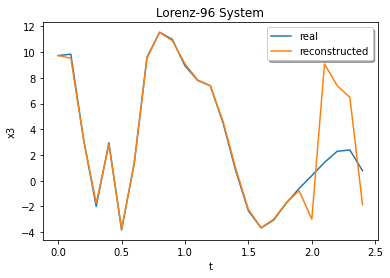

In [193]:
with torch.no_grad():
    # collection of all hidden states
    hidden_data = lin_net(data)
    hidden_data_generated = dy_net(hidden_data[0,:])

T_test = T + 0.5
t_test = np.arange(0.0, T_test, t_step)

test_index = 3

z = RK45_result.sol(t_test)[test_index]

test_hidden = hidden_data_generated.detach().clone()
# print(test_hidden.numel())
for i in range((int)((T_test - T)/t_step)):
    prev = test_hidden[-1,:]
    nxt = (prev + dy_net.M.data @ prev).reshape((1,prev.numel()))
    test_hidden = torch.cat([test_hidden,nxt], dim=0)

test_rec = rec_net(test_hidden)
# z = 0.01*np.sum(z, axis=0)
plt.plot(t_test, z.T)

test_plot = test_rec[:,test_index].detach().numpy().T
plt.plot(t_test[:], test_plot[:])
plt.xlabel('t')
plt.ylabel(f'x{test_index}')
plt.legend(['real', 'reconstructed'], shadow=True)
plt.title('Lorenz-96 System')
plt.show()

In [1185]:
print(dy_net.b)

Parameter containing:
tensor([ 0.3107, -1.5707, -1.0184, -0.9338,  0.2843,  0.1653, -0.2064,  0.9701,
        -0.3413,  0.6369], requires_grad=True)


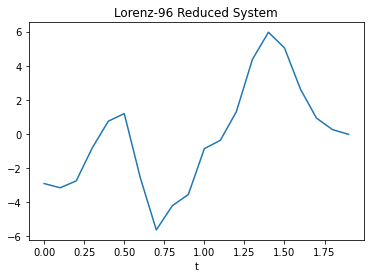

In [1021]:
with torch.no_grad():
    # collection of all hidden states
    hidden_data = lin_net(data)
    hidden_data_generated = dy_net(hidden_data[0,:])

plt.plot(t_test[:], hidden_data[:,0].detach().numpy().T)
plt.xlabel('t')
plt.title('Lorenz-96 Reduced System')
plt.show()



# Train the Transformer

In [79]:
z = RK45_result.sol(t).T
# observe first 5 entried
N = 5
z = z[:,:5]
data = torch.from_numpy(z).float()

lin_net_2 = LinearizationNet(N, d)
dy_net_2 = DynamicsNetSingle(T_steps, t_step, d)
rec_net_2 = ReconstructionNet(N, d)
ker_net_2 = KernelTransformer(N, d, t_step)

opt_lin_2 = optim.Adam(lin_net_2.parameters(), lr=0.1*lr)
opt_dy_2 = optim.Adam(dy_net_2.parameters(), lr=0.01*lr)
opt_ker_2 = optim.Adam(ker_net_2.parameters(), lr=0.01*lr)
opt_rec_2 = optim.Adam(rec_net_2.parameters(), lr=0.1*lr)

In [80]:
# lambda for reconstruction loss
lmbda = 1
# alphas for time normalization
# alphas = [0.5, 0.25, 0.1, 0.03, 0.005]
alphas = [0.5,  0.1, 0.005]
# alphas = [0.005, 0.005, 0.005]
# Linearization Training Loop
for a in range(len(alphas)):
    # set the current time scale. note this is a vector of lenth (T_steps)
    time_scale = torch.exp(-alphas[a]*k).reshape((T_steps-1,1))

    # LR reset
    for g in opt_lin_2.param_groups:
        g['lr'] = 0.1*lr
    for g in opt_rec_2.param_groups:
        g['lr'] = 0.1*lr
    for g in opt_dy_2.param_groups:
        g['lr'] = 0.01*lr
    for g in opt_ker_2.param_groups:
        g['lr'] = 0.01*lr

    for i in range(3000):
        # zero the parameter gradients
        lin_net_2.zero_grad()
        dy_net_2.zero_grad()
        rec_net_2.zero_grad()
        ker_net_2.zero_grad()

        # forward
        outputs = lin_net_2(data)
        # apply linear transformations
        outputs_generated = torch.zeros((T_steps, d))
        outputs_generated[0,:] = outputs[0,:]
        for j in range(T_steps-1):

            prv = outputs_generated[j,:].clone()

            # nxt = dy_net_2(prv) + ker_net_2(data[:j+1,:], prv)
            nxt = dy_net_2(prv)

            outputs_generated[j+1,:] = nxt

        loss = 0.5*(((outputs[1:,:] - outputs_generated[1:,:])).pow(2)*time_scale).sum()
        # reconstruction loss
        reconstructed = rec_net_2(outputs)
        loss += 0.5*lmbda*(reconstructed - data).pow(2).sum()

        if loss < 1e-6:
            print(f'this is loss {loss}')
            break

        if i % 100 == 0:
            print(f'loss {loss} step {i} alpha {alphas[a]}')
        # backward
        loss.backward()

        # optimize
        opt_lin_2.step()
        opt_dy_2.step()
        opt_rec_2.step()
        opt_ker_2.step()

        # LR drop
        # Set new lr
        if i == 1000:
            # lr = 0.6*lr
            for g in opt_lin_2.param_groups:
                g['lr'] = 0.05*lr
            for g in opt_rec_2.param_groups:
                g['lr'] = 0.05*lr
            for g in opt_dy_2.param_groups:
                g['lr'] = 0.005*lr
            for g in opt_ker_2.param_groups:
                g['lr'] = 0.005*lr

        # LR drop
        # Set new lr
        if i == 4000:
            # lr = 0.6*lr
            for g in opt_lin_2.param_groups:
                g['lr'] = 0.01*lr
            for g in opt_rec_2.param_groups:
                g['lr'] = 0.01*lr
            for g in opt_dy_2.param_groups:
                g['lr'] = 0.001*lr
            for g in opt_ker_2.param_groups:
                g['lr'] = 0.001*lr

print(f'final loss: {loss}')
print('done!')

loss 3113.939208984375 step 0 alpha 0.5
loss 9.475427627563477 step 100 alpha 0.5
loss 28.53350830078125 step 200 alpha 0.5
loss 1.6231958866119385 step 300 alpha 0.5
loss 1.1435556411743164 step 400 alpha 0.5
loss 20.509754180908203 step 500 alpha 0.5
loss 11.202547073364258 step 600 alpha 0.5
loss 3.4397950172424316 step 700 alpha 0.5
loss 34.68144226074219 step 800 alpha 0.5
loss 1.7307078838348389 step 900 alpha 0.5
loss 1.026688575744629 step 1000 alpha 0.5
loss 0.7161397933959961 step 1100 alpha 0.5
loss 0.5361343026161194 step 1200 alpha 0.5
loss 0.42925935983657837 step 1300 alpha 0.5
loss 0.4252404272556305 step 1400 alpha 0.5
loss 0.30467477440834045 step 1500 alpha 0.5
loss 32.83409881591797 step 1600 alpha 0.5
loss 2.502683401107788 step 1700 alpha 0.5
loss 1.2150859832763672 step 1800 alpha 0.5
loss 0.7540132403373718 step 1900 alpha 0.5
loss 0.8091458082199097 step 2000 alpha 0.5
loss 0.503180980682373 step 2100 alpha 0.5
loss 0.4598070979118347 step 2200 alpha 0.5
loss 0

In [52]:
outputs_generated

tensor([[ 0.1285, -0.1145,  0.2328,  ...,  2.7306,  0.0778, -0.3622],
        [ 0.1706, -0.1408,  0.2452,  ...,  2.7592,  0.0953, -0.3798],
        [ 0.2144, -0.1665,  0.2557,  ...,  2.7875,  0.1094, -0.3943],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]],
       grad_fn=<CopySlices>)

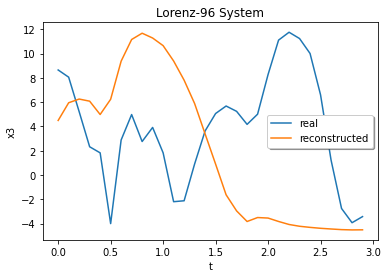

In [81]:
with torch.no_grad():
    # collection of all hidden states
    hidden_data = lin_net_2(data)
    hidden_data_generated = torch.zeros(T_steps, d)

T_test = T
t_test = np.arange(0.0, T_test, t_step)

test_index = 3

z = RK45_result.sol(t_test)[test_index]

test_hidden = hidden_data_generated.detach().clone()
# print(test_hidden.numel())
for i in range(T_steps-1):
    prev = test_hidden[i,:]
    # nxt = dy_net_2(prv) + ker_net_2(data[:j+1,:], prv)
    nxt = dy_net_2(prev)
    test_hidden[i+1,:] = nxt

for i in range((int)((T_test - T)/t_step)):
    prev = test_hidden[-1,:]
    nxt = dy_net_2(prv) + ker_net_2(data[:j+1,:], prv)
    test_hidden = torch.cat([test_hidden,nxt], dim=0)

test_rec = rec_net_2(test_hidden)
# z = 0.01*np.sum(z, axis=0)
plt.plot(t_test, z.T)

test_plot = test_rec[:,test_index].detach().numpy().T
plt.plot(t_test[:], test_plot[:])
plt.xlabel('t')
plt.ylabel(f'x{test_index}')
plt.legend(['real', 'reconstructed'], shadow=True)
plt.title('Lorenz-96 System')
plt.show()